# Introduction: A general example

In [1]:
%matplotlib widget

from homopy.methods import *
from homopy.elasticity import *
from homopy.stiffness_plot import *


In [2]:
# define fiber and matrix properties
carbon_fiber = Isotropy(242e9, 0.1)
v_frac_carbon = 0.25
a_carbon = 347
glass_fiber = Isotropy(80e9, 0.22)
v_frac_glass = 0.25
a_glass = 225
polyamid6 = Isotropy(1.18e9, 0.35)


In [3]:
# Mori Tanaka
mt_carbon = MoriTanaka(polyamid6, carbon_fiber, v_frac_carbon, a_carbon)
mt_glass = MoriTanaka(polyamid6, glass_fiber, v_frac_glass, a_glass)
mt_hybrid = MoriTanaka(
    polyamid6,
    [carbon_fiber, glass_fiber],
    [v_frac_carbon / 2, v_frac_glass / 2],
    [a_carbon, a_glass],
    2 * ["ellipsoid"],
)

# Extract effective stiffness
c_eff_carbon = mt_carbon.get_effective_stiffness()
c_eff_glass = mt_glass.get_effective_stiffness()
c_eff_hybrid = mt_hybrid.get_effective_stiffness()

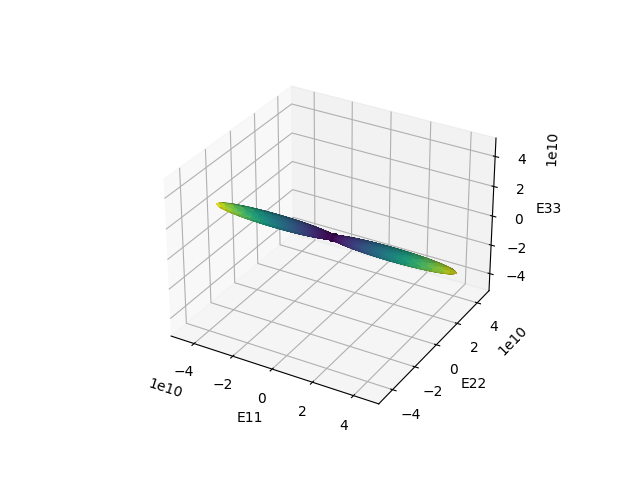

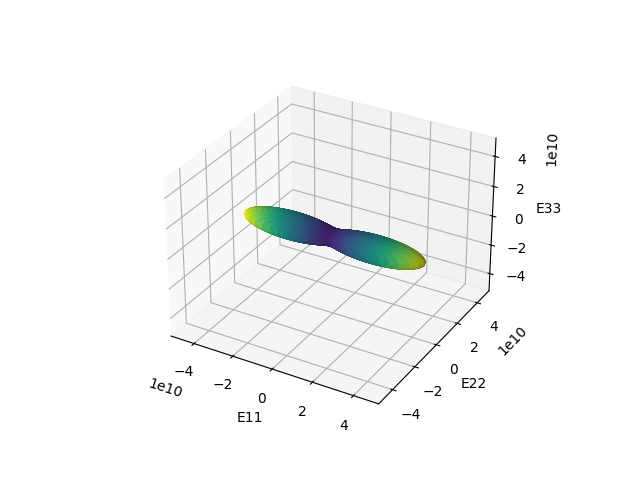

In [4]:
# Orientation averaging (install fiberoripy through "python3 -m pip install fiberoripy"
# or use your own orientation tensor of 2nd and 4th order)
from fiberoripy.closures import (
    IBOF_closure,
    compute_closure,
    hybrid_closure,
    linear_closure,
    quadratic_closure,
)

plotter = ElasticPlot(USEVOIGT=False)  # we highly recommend using USEVOIGT=False

# define arbitrary orientation tensor of 2nd order
N2 = np.zeros((3, 3))
N2[0, 0] = 26 / 32
N2[1, 1] = 3 / 32
N2[2, 2] = 3 / 32

# use closure to estimate orientation tensor of 4th order
N4 = IBOF_closure(N2)  # IBOF_closure is recommended by the authors

# calculate average Mori-Tanaka stiffness and compliance
c_eff_carbon_ave = mt_carbon.get_average_stiffness(N4)
s_eff_carbon_ave = np.linalg.inv(c_eff_carbon_ave)

# plot stiffness body of UD reinforcement...
_ = plotter.plot_E_body(
    c_eff_carbon, 400, 200, [5e10, 5e10, 5e10], rcount=500, ccount=500
)  # rcount and ccount should be larger than default
# ... and averaged reinforcement
_ = plotter.plot_E_body(
    c_eff_carbon_ave, 400, 200, [5e10, 5e10, 5e10], rcount=200, ccount=200
)



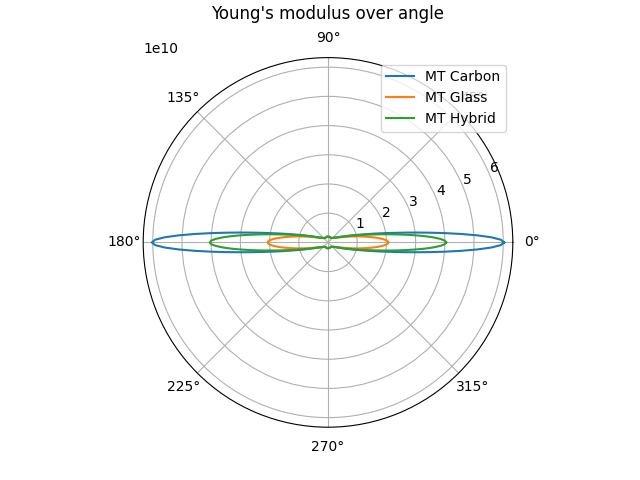

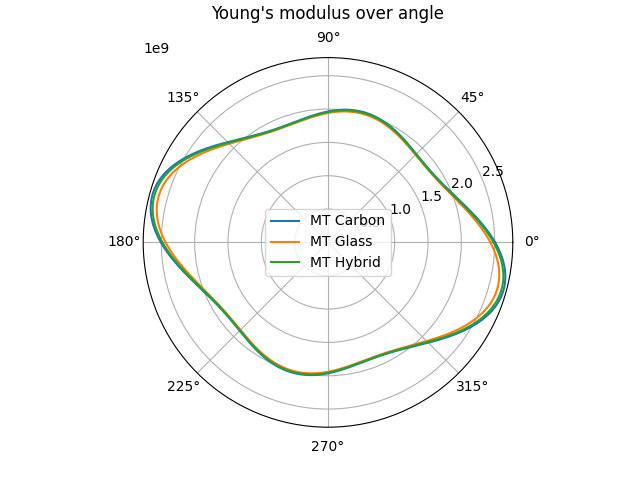

In [5]:
# if only a slice within a cutting plane should be visualized, use the polar plot function
# the default cutting plane is defined by the normal = [0,0,1]

pC = plotter.polar_plot_E_body(c_eff_carbon, 400, plot=False)
pG = plotter.polar_plot_E_body(c_eff_glass, 400, plot=False)
pH = plotter.polar_plot_E_body(c_eff_hybrid, 400, plot=False)

_ = plotter.polar_plot([pC + ("MT Carbon",), pG + ("MT Glass",), pH + ("MT Hybrid",)])

# other normals can be defined

normal = np.array([1,1,1])

pC_angled = plotter.polar_plot_E_body(c_eff_carbon, 400, normal=normal, plot=False)
pG_angled  = plotter.polar_plot_E_body(c_eff_glass, 400, normal=normal, plot=False)
pH_angled  = plotter.polar_plot_E_body(c_eff_hybrid, 400, normal=normal, plot=False)

_ = plotter.polar_plot([pC_angled + ("MT Carbon",), pG_angled + ("MT Glass",), pH_angled + ("MT Hybrid",)])

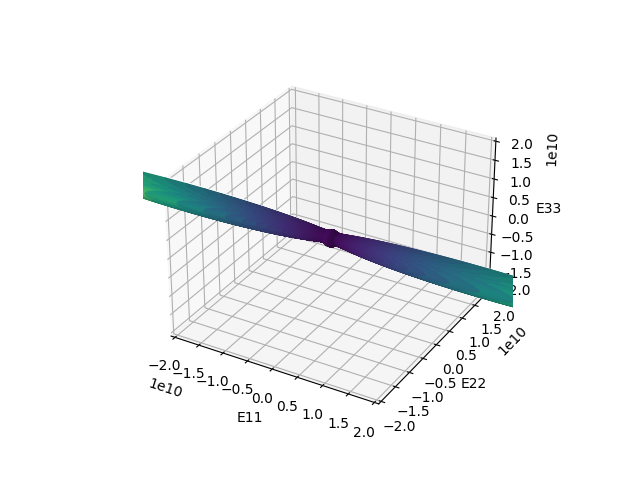

In [13]:
# if you want to visualize the slice in 3D, just go ahead with ...


plotter.plot_E_body_cut(c_eff_carbon, 800, 200, normal=np.array([0,1,0]), bound=[2e10, 2e10, 2e10], rcount=400, ccount=400)

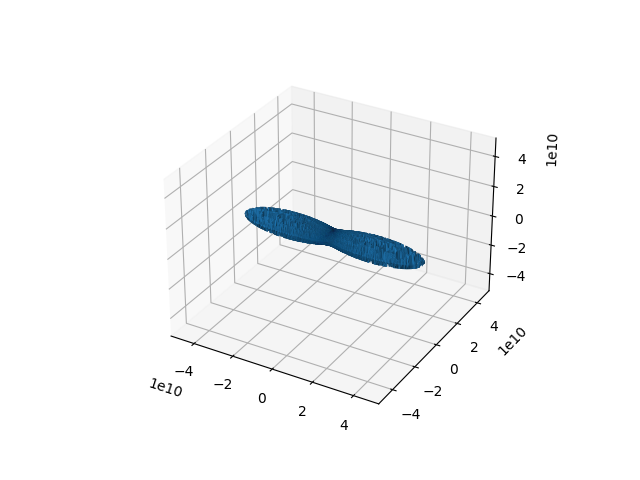

In [7]:
from matplotlib import colors, cm

# A neat 3D visualization of the cutting plane can be achieved by the following ...
rng = 5e10
pts = 1e3

# first evaluate an E-body without plotting
dir_vecs, youngs_moduli = plotter.plot_E_body(
    c_eff_carbon_ave, 400, 200, [rng, rng, rng], rcount=200, ccount=200, plot=False
)

# weight all directions with the stiffness in that direction
weighted_dir_vecs = np.array(
    [youngs_moduli[i] * dir_vecs[i, :] for i in range(len(youngs_moduli))]
)

x = weighted_dir_vecs[:,0]
y = weighted_dir_vecs[:,1]
z = weighted_dir_vecs[:,2]

# create colormap according to x-value 
color_dimension = youngs_moduli
minn, maxx = color_dimension.min(), color_dimension.max()
norm = colors.Normalize(minn, maxx)
m = plt.cm.ScalarMappable(norm=norm, cmap='jet')
m.set_array([])
fcolors = cm.jet(youngs_moduli) #  m.to_rgba(color_dimension)

ax = plt.figure().add_subplot(projection='3d')

ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True, facecolors=fcolors)

_ = ax.set_xlim(-rng,rng)
_ = ax.set_ylim(-rng,rng)
_ = ax.set_zlim(-rng,rng)

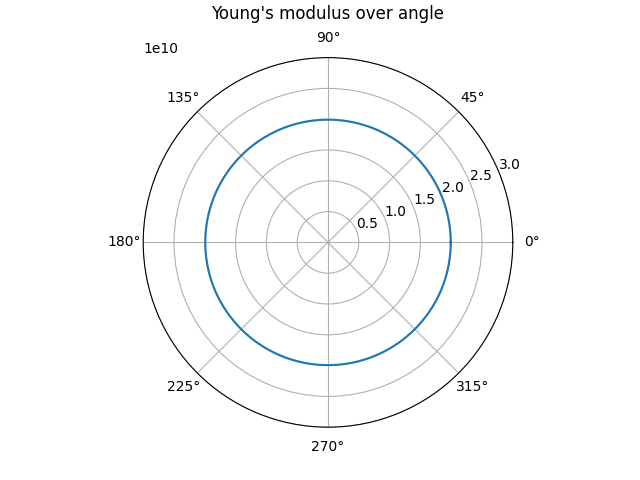

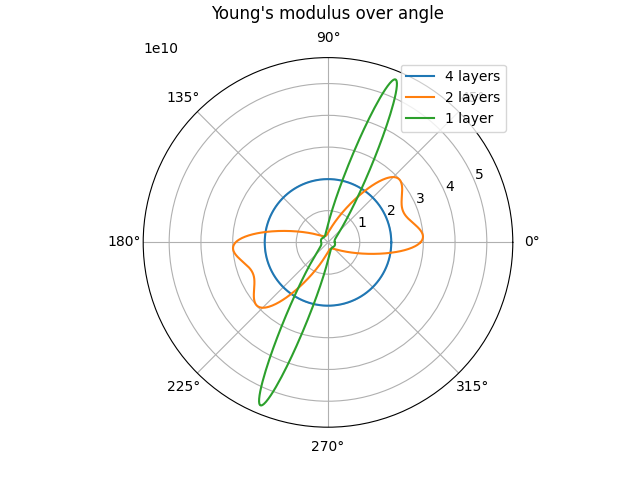

(<Figure size 640x480 with 1 Axes>,
 <PolarAxesSubplot:title={'center':"Young's modulus over angle"}>)

In [8]:
# Halpin-Tsai

# define properties
E_carbon = 242e9
G_carbon = 105e9
nu_carbon = 0.1
l_carbon = 1.5e-3
r_carbon = 7.2 / 2 * 1e-6
vol_carbon = 0.25
E_pa6 = 1.18e9
G_pa6 = 0.4e9
nu_pa6 = 0.35

ht_carbon = HalpinTsai(
    E_carbon,
    E_pa6,
    G_carbon,
    G_pa6,
    nu_carbon,
    nu_pa6,
    l_carbon,
    r_carbon,
    vol_carbon,
)

# create array of laminas and according angles
laminas = 4 * [
    ht_carbon.get_effective_stiffness()
]  # individual stiffnesses possible, e.g. [stiffness1, stiffness2, ...]
pi = np.pi
angles = [0, pi / 4, -pi / 4, pi / 2]

# define laminate
laminate1 = Laminate(laminas, angles)

# plot laminate directly via...
plotter.polar_plot_laminate(laminate1.get_effective_stiffness(), 1000, limit=3e10)

# repeat...
laminas = 2 * [ht_carbon.get_effective_stiffness()]
angles = [0, pi / 4]
laminate2 = Laminate(laminas, angles)

laminas = 1 * [ht_carbon.get_effective_stiffness()]
angles = [3 / 8 * pi]
laminate3 = Laminate(laminas, angles)

pHT1 = plotter.polar_plot_laminate(
    laminate1.get_effective_stiffness(), 1000, plot=False
)
pHT2 = plotter.polar_plot_laminate(
    laminate2.get_effective_stiffness(), 1000, plot=False
)
pHT3 = plotter.polar_plot_laminate(
    laminate3.get_effective_stiffness(), 1000, plot=False
)

# ...or plot a collection of laminates
plotter.polar_plot([pHT1 + ("4 layers",), pHT2 + ("2 layers",), pHT3 + ("1 layer",)])
